In [10]:
from typing import TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv # used to store secret stuff like API keys or configuration values
load_dotenv()

True

In [16]:
class AgentState(TypedDict):
    messages: List[HumanMessage]

llm = ChatOpenAI(model="gpt-4o")

def process(state: AgentState) -> AgentState:
    response = llm.invoke(state["messages"])
    print(f"\nAI: {response.content}")
    return state

In [17]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END) 
agent = graph.compile()


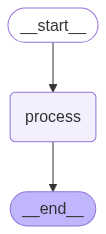

In [18]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
user_input = input("Enter: ")
while user_input != "exit":
    agent.invoke({"messages": [HumanMessage(content=user_input)]})
    user_input = input("Enter: ")

In [1]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b 

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]

model = ChatOpenAI(model = "gpt-4o").bind_tools(tools)


def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState): 
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"
    

graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

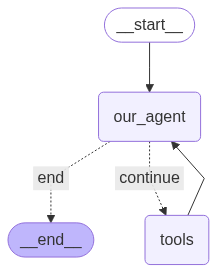

In [3]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))